# Crosscoders
Attempting to recreate the SAE model Anthropic wrote about recently.

Its a SAE which is layer and model agnostic.

I'm not sure about the model agnostic part, but I have an idea about layer the layer agnostic part.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForCausalLM

from datasets import load_dataset

In [158]:
DEVICE = "mps"

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-Coder-0.5B")
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-Coder-0.5B").to(DEVICE)
model.eval()

tokens = tokenizer.encode("print(\"Hello", return_tensors="pt").to(DEVICE)
generation = model.generate(tokens, max_new_tokens=20, pad_token_id=tokenizer.eos_token_id)
print(tokenizer.decode(generation[0], skip_special_tokens=True))

print("Hello World")
print("Hello World")
print("Hello World")
print("Hello World")
print("Hello


We can very simply get the hidden states by setting output_hidden_states=True flag.

In [3]:
out = model(tokens, output_hidden_states=True)

# train SAE on these
len(out.hidden_states), out.hidden_states[0].shape


(25, torch.Size([1, 1, 896]))

and we can register hooks to modify the activations as we please.

In [4]:
layer = model.model.layers[0].mlp.up_proj

hook = layer.register_forward_hook(lambda module, input, output: output * 0)

generation = model.generate(tokens, max_new_tokens=20, pad_token_id=tokenizer.eos_token_id)
print(tokenizer.decode(generation[0], skip_special_tokens=True))

hook.remove()

generation = model.generate(tokens, max_new_tokens=20, pad_token_id=tokenizer.eos_token_id)
print(tokenizer.decode(generation[0], skip_special_tokens=True))

Hello///....    to to//// H HO 
Hello, I am trying to create a function that takes a list of numbers and returns the sum of all


The sparse autoencoder itself is quite simple. It's a traditional autoencoder, but with a twist: instead of 'compressing' the input through a bottleneck, it's overcomplete - meaning it has a larger hidden size than the input size.

There are different ways of achieving sparsity in these activations. One popular formulation uses a top_k activation function to ensure only the k most important features remain active, while others methods directly optimize for sparsity through various loss terms.

The model is trained to reconstruct its input from these sparse activations using reconstruction loss. We can also evaluate its effectiveness by measuring "recovered" loss - essentially comparing the next-token prediction accuracy (via negative log-likelihood) both before and after applying the SAE intervention. This helps us understand how well the SAE preserves the important information from the original representations.

In [5]:
BATCH_SIZE = 8
SEQ_LEN = 64
HIDDEN_SIZE = model.config.hidden_size

def collate_fn(batch):
    tokenized = [tokenizer.encode(item["text"], return_tensors="pt")[0] for item in batch]
    tokenized = [seq[:SEQ_LEN] for seq in tokenized]
    
    return {
        "input_ids": nn.utils.rnn.pad_sequence(tokenized, batch_first=True, padding_value=tokenizer.pad_token_id),
        "attention_mask": torch.tril(torch.ones(BATCH_SIZE, SEQ_LEN)).bool()
    }

train_ds = load_dataset("imdb", split="train")
val_ds = load_dataset("imdb", split="test")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [6]:
batch = next(iter(train_loader))

out = model(batch["input_ids"].to(DEVICE), attention_mask=batch["attention_mask"].to(DEVICE), output_hidden_states=True)

# we would then randomly sample from the layers
# and collapase the batch and sequence dimensions

out.hidden_states[0].reshape(-1, HIDDEN_SIZE).shape


torch.Size([512, 896])

In [33]:
class SAE(nn.Module):
    def __init__(self, input_size, hidden_size, top_k=5):
        super().__init__()
        self.top_k = top_k
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        # maybe add a batch norm after the encoder to get a sensible range of values / loss later on
        
    def encode(self, x):
        x = self.encoder(x)
        top_k = torch.topk(x, k=self.top_k)
        sparse = torch.zeros_like(x, device=x.device, dtype=x.dtype)
        sparse.scatter_(1, top_k.indices, top_k.values)
        return top_k.indices, top_k.values
    
    def decode(self, indices, values):
        sparse = torch.zeros(indices.shape[0], indices.shape[1], self.hidden_size).to(indices.device)
        sparse.scatter_(1, indices, values)
        return self.decoder(sparse)

    def forward(self, x):
        indices, values = self.encode(x)
        return self.decode(indices, values)
    
sae = SAE(HIDDEN_SIZE, HIDDEN_SIZE * 2).to(DEVICE)
sae(out.hidden_states[0].reshape(-1, HIDDEN_SIZE)).shape

I am borrowing an idea from diffusion models and will encode at which layer in the transformer model, the SAE is being applied to (in diffusion it would be the level of noise being on the image that it needs to denoise).

Here I implement a sinusoidal positional encoding for the layers. One could also use learnable embeddings, but I fear that would "divide" the expressiveness of the SAE between these embeddings and the SAE itself. Using static Sinusoidal PE sounds like a better option.

In [8]:
import math

N_LAYERS = model.config.num_hidden_layers

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, hidden_size, max_len):
        super().__init__()
        self.hidden_size = hidden_size
        self.max_len = max_len
        
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2) * (-math.log(10000.0) / hidden_size))
        
        pe = torch.zeros(max_len, hidden_size)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)

    def forward(self, x, pos):
        return x + self.pe[pos]

pos_enc = SinusoidalPositionalEncoding(HIDDEN_SIZE, N_LAYERS).to(DEVICE)

Now to train

Firstly, I dislike the habit people have of doing an entire training epoch before validating (especially since datasets can be huge). So I more often than not do the following

In [9]:
def cycle(dl):
    while True: yield from dl

EPOCHS = 1

NUM_STEPS_PER_TRAIN_EPOCH = len(train_loader)
NUM_STEPS_PER_VAL_EPOCH = len(val_loader)

# per epoch
INTERLEAVE_EVERY = 100
N_INTERLEAVES = NUM_STEPS_PER_TRAIN_EPOCH // INTERLEAVE_EVERY
N_VALIDATION_STEPS = NUM_STEPS_PER_TRAIN_EPOCH // N_INTERLEAVES


cycled_train = cycle(train_loader)
cycled_val = cycle(val_loader)

In [ ]:
from tqdm import tqdm

optim = Adam(sae.parameters(), lr=1e-3)

train_loss, val_loss = float("inf"), float("inf")
train_losses, val_losses = [], []


def sae_step(batch):
    with torch.no_grad():
        out = model(batch["input_ids"].to(DEVICE), attention_mask=batch["attention_mask"].to(DEVICE), output_hidden_states=True)

    random_layers = torch.randint(0, N_LAYERS, (BATCH_SIZE,))
    inputs = torch.cat([out.hidden_states[i].reshape(-1, HIDDEN_SIZE) for i in random_layers], dim=0)
    random_layers = torch.repeat_interleave(random_layers, SEQ_LEN * BATCH_SIZE)
    inputs = pos_enc(inputs, random_layers)
    reconstructed = sae(inputs)
    return F.mse_loss(reconstructed, inputs)

step_iter = tqdm(range(EPOCHS * NUM_STEPS_PER_TRAIN_EPOCH), desc="Training")
for step in step_iter:
    batch = next(cycled_train)
    
    loss = sae_step(batch)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    train_losses.append(loss.item())
    train_loss = loss.item()
    
    step_iter.set_postfix({"Train Loss": f"{train_loss:.4f}", "Val Loss": f"{val_loss:.4f}"})
    
    if step % INTERLEAVE_EVERY == 0:
        interleaved_losses = []
        for _ in range(N_VALIDATION_STEPS):
            with torch.no_grad():
                batch = next(cycled_val)
                loss = sae_step(batch)
                interleaved_losses.append(loss.item())
                
                val_loss = loss.item()
                
                step_iter.set_postfix({"Train Loss": f"{train_loss:.4f}", "Val Loss": f"{val_loss:.4f}"})

        val_loss = sum(interleaved_losses) / len(interleaved_losses)
        val_losses.append(val_loss)


Skipping the first few steps to see the trend later on.

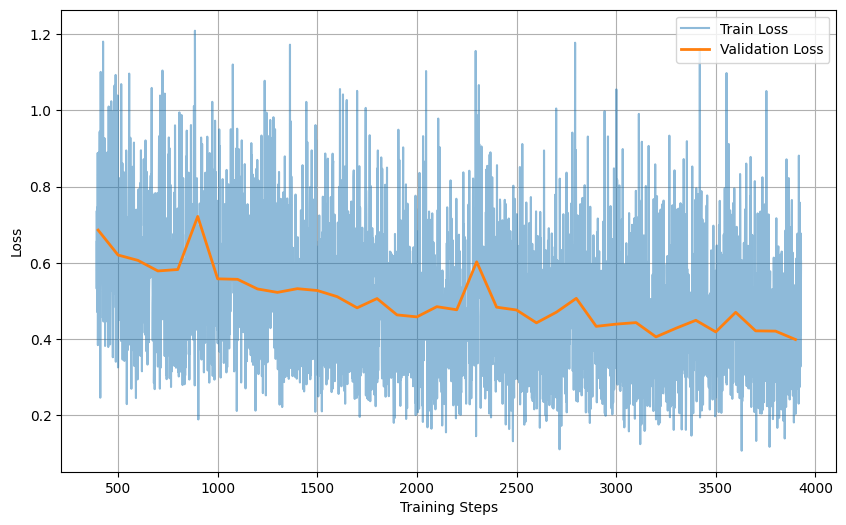

In [13]:
from matplotlib import pyplot as plt

train_steps = range(len(train_losses))
val_steps = range(0, len(train_losses), INTERLEAVE_EVERY)[:len(val_losses)]

plt.figure(figsize=(10, 6))
plt.plot(train_steps[len(train_steps)//10:], train_losses[len(train_losses)//10:], label='Train Loss', alpha=0.5)
plt.plot(val_steps[len(val_steps)//10:], val_losses[len(val_losses)//10:], label='Validation Loss', linewidth=2)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Still trending downwards, only trained this for 20-30 minutes on my mac. 

Now we can try to see whether the SAE is picking up on something interesting.

In [23]:
subset = val_ds.shuffle(seed=42).select(range(100))
positives = [x["text"] for x in subset if x["label"] == 1]
negatives = [x["text"] for x in subset if x["label"] == 0]

positives = [tokenizer.encode(x, return_tensors="pt") for x in positives]
negatives = [tokenizer.encode(x, return_tensors="pt") for x in negatives]

len(positives), len(negatives)

(47, 53)

In [36]:
LAYER = model.config.num_hidden_layers // 2  # maybe the middle is interesting

with torch.no_grad():
    positive_activations = [model(x.to(DEVICE), output_hidden_states=True).hidden_states[LAYER].reshape(-1, HIDDEN_SIZE) for x in tqdm(positives)]
    negative_activations = [model(x.to(DEVICE), output_hidden_states=True).hidden_states[LAYER].reshape(-1, HIDDEN_SIZE) for x in tqdm(negatives)]

    positive_activations = torch.cat(positive_activations, dim=0)
    negative_activations = torch.cat(negative_activations, dim=0)
    
    positive_indices, positive_values = sae.encode(positive_activations)
    negative_indices, negative_values = sae.encode(negative_activations)


In [81]:
positive_counts = torch.bincount(positive_indices.flatten(), minlength=HIDDEN_SIZE * 2)
negative_counts = torch.bincount(negative_indices.flatten(), minlength=HIDDEN_SIZE * 2)

sorted_indices = torch.sort(positive_counts + negative_counts, descending=True).indices


In [155]:
def highlight_feature_activations(text, feature_idx, model, sae, tokenizer, device="mps"):
    # ANSI color codes for background
    RESET = "\033[0m"
    def get_color(value):
        normalized = math.log(value + 1e-5) / math.log(torch.tensor(100.0))  # arbitrarily scaling to get nicer colors
        normalized = max(0.0, min(1.0, normalized))  # clip to 0-1
        
        # Create a yellow-orange gradient
        r = int(255 * normalized)
        g = int(200 * normalized)
        b = int(50 * normalized)
        
        return f"\033[48;2;{r};{g};{b}m"
    
    # Tokenize and get model outputs
    tokens = tokenizer.encode(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(tokens, output_hidden_states=True)
        hidden_states = outputs.hidden_states[LAYER]
        hidden_states = hidden_states.reshape(-1, model.config.hidden_size)
        indices, values = sae.encode(hidden_states)
        
        # Create feature mask
        feature_mask = (indices == feature_idx).any(dim=1)
        feature_values = torch.zeros_like(feature_mask, dtype=torch.float)
        for i, (idx, val) in enumerate(zip(indices, values)):
            if feature_idx in idx:
                feature_values[i] = val[idx == feature_idx].max()
    
    # Decode tokens and apply colors
    tokens = tokens[0].cpu().numpy()
    decoded = []
    for i, token in enumerate(tokens):
        word = tokenizer.decode([token])
        if feature_mask[i]:
            color = get_color(feature_values[i].item())
            decoded.append(f"{color}{word}{RESET}")
        else:
            decoded.append(word)
    
    return "".join(decoded)

def highlight_feature(text, feature_idx, model, sae, tokenizer, device="mps"):
    example_text = tokenizer.decode(text[0], skip_special_tokens=True)
    colored_text = highlight_feature_activations(example_text, feature_idx, model, sae, tokenizer)
    print(colored_text)

Now we can at last highlight the features.

The most common activations appear to "overfire" in this small example we have done. 

In [88]:
highlight_feature(positives[1], sorted_indices[0], model, sae, tokenizer)
highlight_feature(negatives[1], sorted_indices[0], model, sae, tokenizer)

This is the latest entry in the long series of films with the French agent, O.S.S. 117 (the French answer to James Bond). The series was launched in the early 1950's, and spawned at least eight films (none of which was ever released in the U.S.). 'O.S.S.117:Cairo,Nest Of Spies' is a breezy little comedy that should not...repeat NOT, be taken too seriously. Our protagonist finds himself in the middle of a spy chase in Egypt (with Morroco doing stand in for Egypt) to find out about a long lost friend. What follows is the standard James Bond/Inspector Cloussou kind of antics. Although our man is something of an overt xenophobe,sexist,homophobe, it's treated as pure farce (as I said, don't take it too seriously). Although there is a bit of rough language & cartoon violence, it's basically okay for older kids (ages 12 & up). As previously stated in the subject line, just sit back,pass the popcorn & just enjoy.
This movie spends most of its time preaching that it is the script that makes the

Some features I have naively labelled

"Referring to someone or something" feature

In [98]:
highlight_feature(positives[2], sorted_indices[8], model, sae, tokenizer)
highlight_feature(negatives[2], sorted_indices[8], model, sae, tokenizer)

I was truly and wonderfully surprised at "O' Brother, Where Art Thou?" The video store was out of all the movies I was planning on renting, so then I came across this. I came home and as I watched I became engrossed and found myself laughing out loud. The Coen's have made a magnificiant film again. But I think the first time you watch this movie, you get to know the characters. The second time, now that you know them, you laugh sooo hard it could hurt you. I strongly would reccomend ANYONE seeing this because if you are not, you are truly missing a film gem for the ages. 10/10
Don't pay any attention to the rave reviews of this film here. It is the worst Van Damme film and one of the worst of any sort I have ever seen. It would appeal to somebody with no depth whatever who requires nothing more than gunfire and explosions to be entertained.<br /><br />Seeing that this is directed by Peter Hyams it has made me realise that Peter has no talent as a director, but is very good at filming e

"End of sentence" feature

In [105]:
highlight_feature(positives[3], sorted_indices[10], model, sae, tokenizer)
highlight_feature(negatives[3], sorted_indices[10], model, sae, tokenizer)

After a very long time Marathi cinema has come with some good movie.This movie is one of the best Marathi movies ever made. It shows how a old grandfather tries to save his grandsons eye. He tries everything that is possible in his hands to save the child's eye. Doctor and a relative of his tries to help him in his attempt.<br /><br />The acting by the grandfather, the boy and the doctor are simply superb. They have shown true picture of a typical Marathi life. Every bit of action has some meaning in it. I would recommend to watch this movie, as initially I thought this one would be of documentary type but this was above my expectations.<br /><br />This film is really going to touch your hearts.I would expect more Marathi movies to come up with performances like this.
Porn legend Gregory Dark directs this cheesy horror flick that has Glen Jacobs (Kane from WWF/WWE/ whatever it calls itself nowadays) in his cinematic debut. He plays Jacob Goodknight, a blind serial killer who's forte is

The "the" feature

In [110]:
highlight_feature(positives[4], sorted_indices[14], model, sae, tokenizer)
highlight_feature(negatives[4], sorted_indices[14], model, sae, tokenizer)


This is a really sad, and touching movie! It deals with the subject of child abuse. It's really sad, but mostly a true story, because it happens everyday. Elijah Wood and Joseph Mazzello play the two children or Lorraine Bracco, a single mother who just tries to make a home for them. While living with her parents, a man, who likes to be called "The King" comes into their life. He hits the youngest boy, Bobby, but the two brothers vow not to tell their mother. But finally she finds out, after the Bobby is hurt badly. The end kind of ruined it for me, because it is so totally unbelievable. But, except for that, I love the movie.
OK, it was a "risky" move to rent this flick, but I thought I had nothing to lose.Well, I was wrong. This is, next to "Bloodsurf", the worst "horrormovie" I have ever seen. Crappy actors, crappy technical output, crappy story and so on. The soundtrack though, isn't to bad. That is why I give it a 2 on the vote and not just a 1. And of course the cats are a positi

"name" feature

In [114]:
highlight_feature(positives[5], sorted_indices[16], model, sae, tokenizer)
highlight_feature(negatives[5], sorted_indices[16], model, sae, tokenizer)

This was a great movie. Something not only for Black History month but as a reminder of the goodness of people and the statement that it truly does take a village to raise a child. The performances by S Eptath was outstanding. Mos Def and his singing was off the hook. Had to do a double take when I saw that was Rosie Perez there. But the supporting cast of actors and actresses made this worth watching. All the different stories they had was amazing. And how Nanny protected Jr and literally everyone else that was in her presence. I can truly understand her being the matriarch of that time period and even more so how tired she was in helping everyone. Cant wait for it to come out on DVD. It would be a welcome addition to any movie library.
These days, writers, directors and producers are relying more and more on the "surprise" ending. The old art of bringing a movie to closure, taking all of the information we have learned through out the movie and bringing it to a nice complete ending, 

"media" feature?

In [119]:
highlight_feature(positives[6], sorted_indices[20], model, sae, tokenizer)
highlight_feature(negatives[6], sorted_indices[20], model, sae, tokenizer)

If you're a fan of Turkish and Middle Eastern music, you're in great luck. This film is a documentary of current music in Istanbul, spanning the traditional to the modern. It's very good. You could not do better if you went to Istanbul yourself. We get interviews with Orhan Gencebay, concert clips of modern musical icons, a road show with a Romani (Gypsy) audience, Turkish Hip Hop (surprisingly very very good), and much much more. Some of the best female vocalists I've ever heard. A Kurdish woman singing in a hamam (steam bath) who will rip your heart out. Lots of social and political background. If this is your thing, you'll have a grand time. I could barely sit still in the theatre.<br /><br />CD soundtrack now available on amazon. Pricey.
Teenager Tamara (Jenna Dewan) has it rough. She's ridiculed by all the popular "kids" for being shy, bookish, frumpy and because of her interest in witchcraft. All of the football players and cheerleaders are especially angry at her for writing an 

"<'br' /><'br' />" feature, for some reason it was not filtered out of the dataset

In [122]:
highlight_feature(positives[7], sorted_indices[22], model, sae, tokenizer)
highlight_feature(negatives[7], sorted_indices[22], model, sae, tokenizer)

Dirty Harry goes to Atlanta is what Burt called this fantastic, first-rate detective thriller that borrows some of its plot from the venerable Dana Andrews movie "Laura." Not only does Burt Reynolds star in this superb saga but he also helmed it and he doesn't make a single mistake either staging the action or with his casting of characters. Not a bad performance in the movie and Reynolds does an outstanding job of directing it. Henry Silva is truly icy as a hit-man.<br /><br />Detective Tom Sharky (Burt Reynolds) is on a narcotics case in underground Atlanta when everything goes wrong. He winds up chasing a suspect and shooting it out with the gunman on a bus. During the melee, an innocent bystander dies. John Woo's "The Killer" replicates this scene. Anyway, the Atlanta Police Department busts Burt down to Vice and he takes orders from a new boss, Frisco (Charles Durning of "Oh, Brother, Where Art Thou?") in the basement. Sharky winds up in a real cesspool of crime. Sharky and his fe

"counts of something" feature

In [125]:
highlight_feature(positives[8], sorted_indices[24], model, sae, tokenizer)
highlight_feature(negatives[8], sorted_indices[24], model, sae, tokenizer)

I'm 15, usually not kids my age usually watch these old classic movies. But this is one of my favorites. I was totally addicted after watching it for the first time. It's really good if u think about technology and movies back at that time, music is great, storyline is OK,choreography is great, must see it. I don't know why there's a prequel for this movie. Not many people like this movie, but i love classic love movies, they're so much better than movies now! This movie will make you smile, cry and make you start dancing. The music is absolutely ear catching and beautiful. I haven't seen Dirty Dancing 2 Harvana Nights(prequel), prequel should have star the original actors, thats what i hate about prequels, they ruin the original. No one wants a prequel, they want a sequel. Many people will agree that for a movie- the original, sequel and the 3rd one is enough. Beyond that, people wont be bothered to watch it. Who remembers the movie about the St Benard Beethoven? I think there's 5 mov

"description of quality" feature

In [131]:
highlight_feature(positives[9], sorted_indices[28], model, sae, tokenizer)
highlight_feature(negatives[9], sorted_indices[28], model, sae, tokenizer)

Definitely a movie for people who ask only to be entertained and who do not over-think their movies. <br /><br />Lots of action, lots of great dialogue (e.g. fun to quote), a little intrigue, and stuff blowing up all over the place. Samuel L Jackson and Geena Davis had great chemistry. Violent, but not gory. The fact that the female part was the competent action lead is a pleasant turn-about.<br /><br />Have seen the movie more than a dozen times and still enjoy it enough to put it back in my favorite films rotation every 3 or 4 months. I initially rented the movie because Samuel L Jackson was in the film, but was caught up in the events surrounding Samantha's quest to regain her memory and have never looked back.<br /><br />All you cerebral folks out there -- suspend disbelief for once, take yourself a little less seriously -- you might actually enjoy yourselves!
I was expecting a lot more of this film than what I actually got. The acting was just awful from everyone and the story was

a "a" feature

In [136]:
highlight_feature(positives[10], sorted_indices[30], model, sae, tokenizer)
highlight_feature(negatives[10], sorted_indices[30], model, sae, tokenizer)


If Hollywood had the wellbeing of the audience at heart we would see 20 films a year with the kind of wholesome fortitude that is behind this film. There are several experiences of personal growth in this movie and while the characters ARE still very human even the lessons learned are not that greed will profit you, or do-unto-others-whatever-you-want-as-long-as-you-are-okay-with-it, no, this is what our sad, desensitized lives need, more sense... more love... more do-unto-others-as-you-would-have-done-unto-you... more HOPE. (thanks Ursula!) This movie has an intelligent wit, not "yo' mama" cracks that run rampant in the so-called comedies. People need to feel good. This movie will make you feel good and possibly inspire you to better your life, and the lives of others. sidenote Every person counts in ticket sales. This is a truly independent film. If you want more quality films you have to support them.
Coming from Kiarostami, this art-house visual and sound exposition is a surprise. 

This is the "this/these/that/those" feature

In [147]:
highlight_feature(positives[11], sorted_indices[40], model, sae, tokenizer)
highlight_feature(negatives[11], sorted_indices[40], model, sae, tokenizer)

I was so happy to learn that Hari Om will finally be theatrically released in 2007. I saw this film three years ago at the Vancouver International film Festival and have been waiting for it's release ever since so I could send everyone I know to see it. It's like taking a trip to India....colorful, magical, thought provoking. Aside from one rather strange Hollywood style auto rickshaw chase scene this movie is very realistic. This is not a Bollywood style song and dance movie but it does have drama and romance and humor. The interactions between the Indian taxi driver and the french tourist are a good reflection on the fundamental differences between Eastern and Western life styles and philosophy. The characters are a little broadly drawn but the acting was very good. Visually this movie is a treat as you really do get a sense of what driving through Rajasthan is like...dreamlike. Sometimes it's hard to believe everything you are seeing and experiencing is real...the movie has that sam